In [1]:
from keras import backend as K

n_cores = 10

K.set_session(K.tf.Session(config=K.tf.ConfigProto(
    intra_op_parallelism_threads=n_cores, 
    inter_op_parallelism_threads=n_cores)))

from keras.layers import Input, Dense, Lambda
from keras.callbacks import TensorBoard
from keras.models import Model
from keras import regularizers
from keras.datasets import mnist
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
from keras.losses import binary_crossentropy, kullback_leibler_divergence


import numpy as np
import time

import matplotlib.pyplot as plt

tb_session_name = "SAE"
tb_logs = "/home/nanni/tensorboard_logs"

In [2]:
def get_tensorboard_callback():
    return TensorBoard(log_dir="{}/{}__{}".format(tb_logs, tb_session_name,time.strftime('%Y_%m_%d__%H_%M')))

## MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Sparse AutoEncoder

In [14]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu', 
                activity_regularizer=regularizers.l2(10e-7))(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded) 

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# logging and compilation
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Fitting

In [ ]:
autoencoder.fit(x_train, x_train, verbose=0,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[get_tensorboard_callback()])

### Encoding and Decoding

In [ ]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational AutoEncoder

In [7]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

image_size = x_train.shape[1]

# network parameters
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [8]:
inputs = Input(shape=(image_size, ), name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(image_size, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________



References: 
- [Kingma, D. P. & Welling, M. Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf).
- [Doersch, C. Tutorial on Variational Autoencoders. (2016)](https://arxiv.org/pdf/1606.05908.pdf)
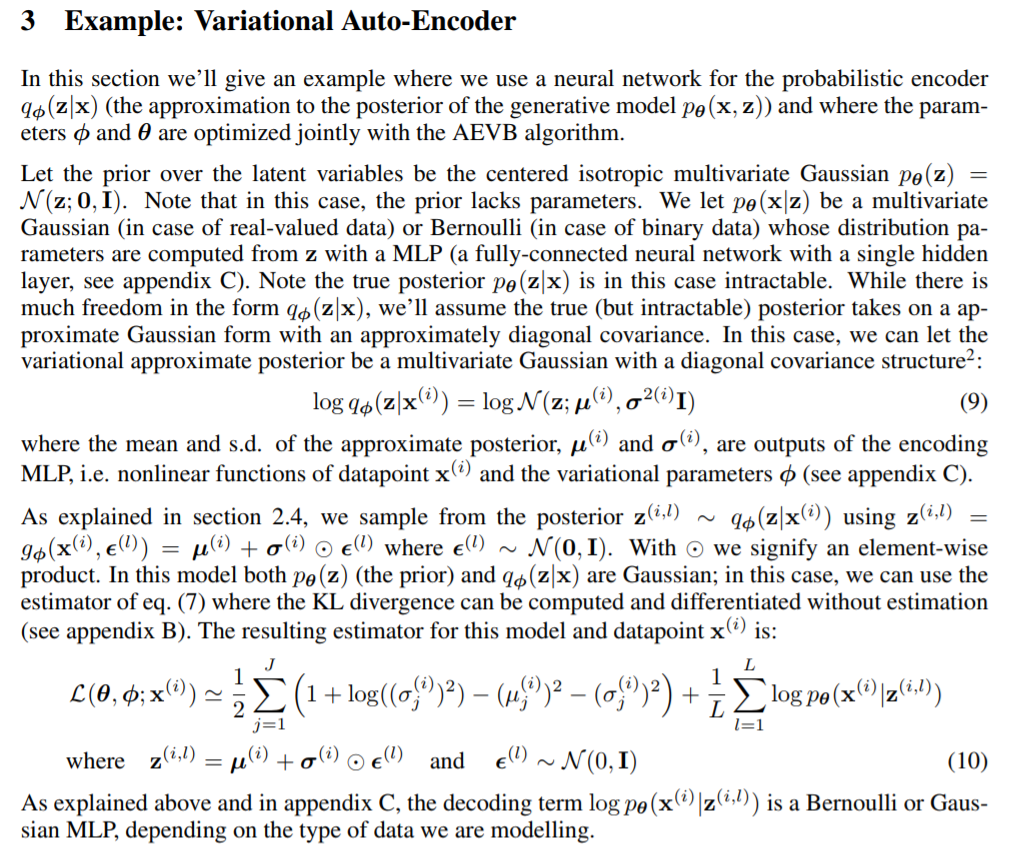

$$
D_{KL}[N(\mathbf z; \mu, \sigma^2) || N(0, 1)] = \frac{1}{2} \, \sum_j \left( \sigma^2_j + \mu^2_j - 1 - \log \sigma^2_j \right)
$$

In practice, however, it’s better to model $\Sigma(X)$ as $\log\Sigma(X)$ as it is more numerically stable to take exponent compared to computing log. Hence, our final KL divergence term is:
$$
D_{KL}[N(\mathbf z;\mu, \sigma^2) || N(0, 1)] = \frac{1}{2} \, \sum_j \left( \exp(\sigma^2_j) + \mu^2_j - 1 - \sigma^2_j \right)
$$

In [9]:
def vae_loss(x, x_decoded):
    xent_loss = binary_crossentropy(x, x_decoded)
    kl_loss = 0.5 * K.mean(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=-1)
    return xent_loss + kl_loss

In [10]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [11]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[get_tensorboard_callback()])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.3006 - val_loss: 0.2632
Epoch 2/50
60000/60000 [==============================] - 7s 111us/step - loss: 0.2631 - val_loss: 0.2629
Epoch 3/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 4/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 5/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.2630 - val_loss: 0.2629
Epoch 6/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.2630 - val_loss: 0.2628
Epoch 7/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 8/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.2630 - val_loss: 0.2629
Epoch 9/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.2630 - val_loss: 0.2627


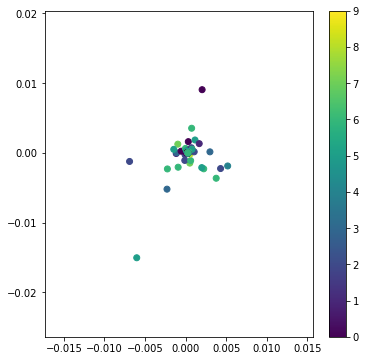

In [44]:
z_mean_test_encoded, z_log_var_test_encoded, z_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_mean_test_encoded[:, 0], z_mean_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()